In [1]:
from tracenet.utils.trainer import Trainer

### Specify parameters

In [2]:
data_path = '/research/sharedresources/cbi/data_exchange/hangrp/Development/mt_detection/data_synth/lines_2D_400/'

In [3]:
config = dict(
    backbone='monai_unet',
    data_dir=data_path,
    epochs=2,
    batch_size=4,
    model_path='models',
    log_tensorboard=True,
    gt_dir='csv',
    n_channels=(16, 32, 64, 128),
    instance=True,
    tracing=True
    )
config

{'backbone': 'monai_unet',
 'data_dir': '/research/sharedresources/cbi/data_exchange/hangrp/Development/mt_detection/data_synth/lines_2D_400/',
 'epochs': 2,
 'batch_size': 4,
 'model_path': 'models',
 'log_tensorboard': True,
 'gt_dir': 'csv',
 'n_channels': (16, 32, 64, 128),
 'instance': True,
 'tracing': True}

### Set up trainer

In [4]:
trainer = Trainer(**config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Using cache found in /home/amedyukh/.cache/torch/hub/facebookresearch_detr_main


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.97it/s]


epoch 1 training loss: 3.3785


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00, 11.95it/s]


epoch 1 validation loss: 2.7210
Saved model to: models/2022-09-22-14-43-35/last_model.pth
Saved model to: models/2022-09-22-14-43-35/best_model.pth


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.08it/s]


epoch 2 training loss: 2.5237


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00, 11.67it/s]


epoch 2 validation loss: 2.5322
Saved model to: models/2022-09-22-14-43-35/last_model.pth
Saved model to: models/2022-09-22-14-43-35/best_model.pth


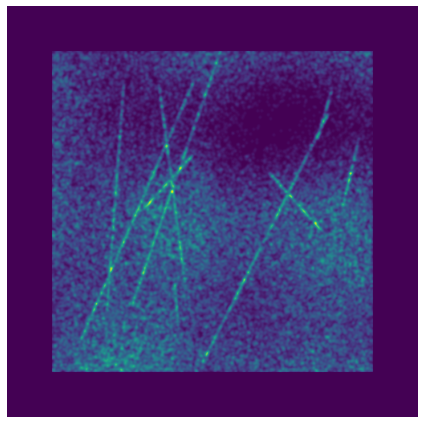

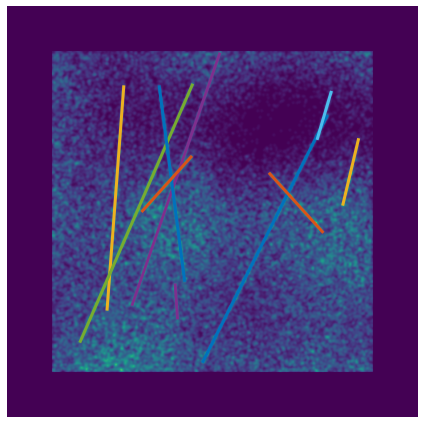

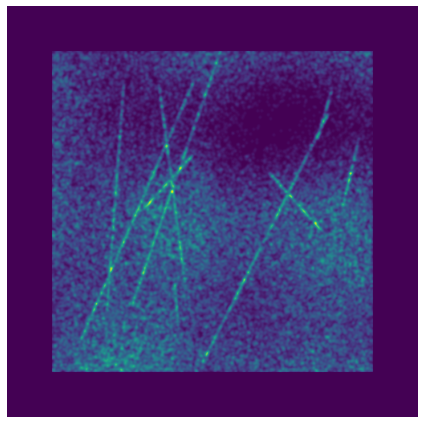

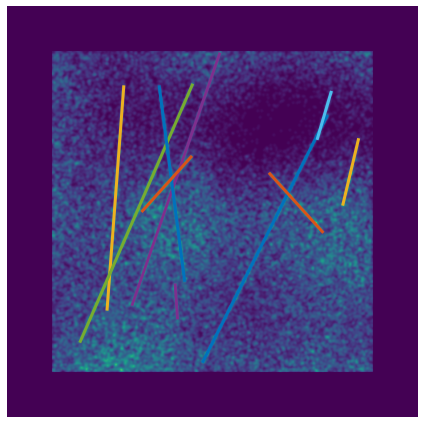

In [5]:
trainer.train()